In [11]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
# Modify path to find code directory:
import sys
sys.path.append('../code/')

import networkx as nx
import matplotlib.pyplot as plt


In [13]:
from structures import *


In [21]:
agents = [
    Agent(receptivity=0.5,persuasiveness=0.5),
    Agent(receptivity=0.5,persuasiveness=0.5),
    Agent(receptivity=0.5,persuasiveness=0.5),
    Agent(receptivity=0.5,persuasiveness=0.5),
    Agent(receptivity=0.5,persuasiveness=0.5),
]

# Add some connections (only use inner circle):
agents[0].inner_circle.append(agents[1].id)
agents[1].inner_circle.append(agents[0].id)
agents[1].inner_circle.append(agents[2].id)
agents[2].inner_circle.append(agents[1].id)
agents[1].inner_circle.append(agents[3].id)
agents[3].inner_circle.append(agents[1].id)
agents[3].inner_circle.append(agents[4].id)
agents[4].inner_circle.append(agents[3].id)

# - REMINDER - Do we want to have connections automatically propagate both ways when specified?

# Build simulation environment:
env = Environment(agents, seed=182)
print(env)


<Environment with 0/5 informed agents>


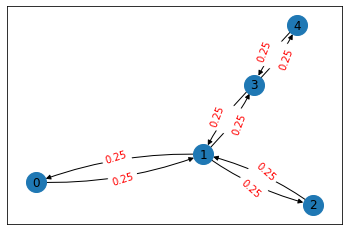

In [22]:
env.plot_network_graph()
